# PROJETO INTEGRADOR III - Modelo de aprendizagem de máquina

### Parâmetros que podem ser usados para definir a aprovação:

- nota (de cada área de conhecimento e com peso, mesmo que todos sejam iguais a 1);
- cotas (vou precisar tratar isso aqui);
- notas de corte;
- curso (vou precisar tratar isso aqui);
- universidade (vou precisar tratar isso aqui: campus, IES ou o que?);
- Local da IES;
- local do candidato;


### feature engineering

pontos importantes para serem destacados:

- *notas*: tratar os dados que estão fora da distribuição normal;
- *cotas, curso e universidade*: considerar usar um target encoding ou count encoding;
- *notas de corte*: talvez não será necessário passar por um tratamento;
- *locais*: pode ser usado um label encoding, mas é necessário avaliar o contexto. oneHotEncoding seria muito custoso ( 27 * 2 + 54 = 108 colunas).


### Avaliação de modelo de linguagem
precisão, recall, acurácia e área sob a curva ROC (Receiver Operating Characteristic).


In [1]:
# dataframes
import pandas as pd
import numpy as np

# visualizacao
import matplotlib.pyplot as plt

# conexão com o banco de dados
import psycopg2 as pspg
CONN = pspg.connect(database='notas', user='dev', password='dev', host='localhost', port='5030')

# feature engineering
from category_encoders.count import CountEncoder
from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder )

# algoritmos de classificação 
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors

# metricas e validacoes
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve )
from sklearn.model_selection import cross_val_score, train_test_split


In [2]:
df = pd.read_sql('''
  select 
    nota_l,
    nota_ch,
    nota_cn,
    nota_m,
    nota_r,
    nota_l_com_peso,
    nota_ch_com_peso,
    nota_cn_com_peso,
    nota_m_com_peso,
    nota_r_com_peso,
    nota_candidato,
    tipo_mod_concorrencia,
    tp_cota,
    uf_ies,
    uf_candidato,
    nome_curso,
    nome_ies,
    aprovado  
  from sisu_data
  tablesample bernoulli(35)
  ''', con=CONN)
CONN.close()

/tmp/ipykernel_570194/924614866.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('''


## ENGINEERING

## modalidade de concorrência: _one hot encoding_

tirando espaços em branco da coluna `tp_cota`

In [3]:
df['tp_cota'] = df['tp_cota'].str.strip()
df['tp_cota'].unique()

array([None, 'PPI', 'D', 'PPID', 'DD', 'I', 'PP', 'PPD'], dtype=object)

In [4]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
columns = ['tipo_mod_concorrencia',  'tp_cota']

print(df.shape)
for column in columns:
    transformed = ohe.fit_transform(df[column].values.reshape(-1, 1))
    ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names_out([column]))
    df = pd.concat([df, ohe_df], axis=1)

print(df.shape)

(5409993, 18)
(5409993, 30)


### Unidades Federativas: _Ordinal Encoding_ por ordem de concorrência

In [5]:
ordinals = ['uf_ies', 'uf_candidato', 'aprovado']
le = None
for column in ordinals:
    estados_ordenados = df.groupby(column)['nota_candidato'].mean().sort_values(ascending=False).index
    le = OrdinalEncoder(categories=[estados_ordenados.tolist()])
    df[f"{column}_le"] = le.fit_transform(df[column].values.reshape(-1, 1), estados_ordenados)



## Universidades e Cursos: Codificação de frequência (_Count Encoder_)

In [6]:
counters = [ 'nome_curso', 'nome_ies']
ce = CountEncoder()
for column in counters:
    transformed = ce.fit_transform(df[column].values.reshape(-1, 1))
    df[f"{column}_ce"] = ce.fit_transform(df[column].values.reshape(-1, 1))

### notas: removendo outliers

removendo as notas consideradas _outliers_ do conjunto de dados para fazer o treinamento 

In [7]:
df_filtrado = df.copy()
notas = ['nota_l','nota_ch', 'nota_cn',
        'nota_m', 'nota_r', 'nota_candidato']


for nota in notas:
    primeiro_quartil = df[nota].quantile(0.25)
    terceiro_quartil = df[nota].quantile(0.75)
    iqr = terceiro_quartil - primeiro_quartil
    limite_inferior = primeiro_quartil - 1.5 * iqr
    limite_superior = terceiro_quartil + 1.5 * iqr
    df_filtrado = df_filtrado[(df_filtrado[nota] >= limite_inferior) & (df_filtrado[nota] <= limite_superior)]


In [8]:
# colunas_necessárias
ml_params = [
    'nota_l_com_peso',          #ok
    'nota_ch_com_peso',         #ok
    'nota_cn_com_peso',         #ok
    'nota_m_com_peso',          #ok
    'nota_r_com_peso',          #ok
    'nota_candidato',           #ok
    # 'nota_corte',               # pegar a média do curso por universidade?

#    'qt_vagas_concorrencia',    # ajudaria muito, mas tem muitos registros NaN. sem chances de usar
    # tipo_mod_concorrencia com oneHotEncoder
    'tipo_mod_concorrencia_A', # ok
    'tipo_mod_concorrencia_B', # ok
    'tipo_mod_concorrencia_L', # ok
    'tipo_mod_concorrencia_V', # ok
    'tp_cota_D',               # ok
    'tp_cota_DD',              # ok
    'tp_cota_I',               # ok
    'tp_cota_PP',              # ok
    'tp_cota_PPD',             # ok
    'tp_cota_PPID',            # ok
    'tp_cota_None',            # ok
    'uf_ies_le',                  # ok
    'uf_candidato_le',            # ok
    'nome_curso_ce',
    'nome_ies_ce',
    'aprovado_le',
    ]

output_desejado = 'aprovado_le'

## Treinando o modelo

Modelos de M.L que podem ser usados:
  - *Decision Trees*;
  - *Naive Bayes*;


Divisão para treino, teste e validação

In [9]:
X_train, X_val_test, y_train, y_val_test = \
train_test_split(
    df_filtrado[ml_params].drop(output_desejado, axis=1), 
    df_filtrado[output_desejado], 
    test_size=0.1, 
    random_state=42
)

X_test, X_val, y_test, y_val = \
    train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


In [10]:
n_bayes = MultinomialNB() #.fit(X_train, y_train)
decision_tree_log_loss = DecisionTreeClassifier(random_state=42, criterion='log_loss', max_depth=4) # .fit(X_train, y_train)
decision_tree_gini = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=4) # .fit(X_train, y_train)
decision_tree_entropy = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=4) # .fit(X_train, y_train)
extra_decision_tree_log_loss = ExtraTreeClassifier(random_state=42, criterion='log_loss', max_depth=4, max_features='log2', )
extra_decision_tree_gini = ExtraTreeClassifier(random_state=42, criterion='gini', max_depth=4, max_features='log2')
extra_decision_tree_entropy = ExtraTreeClassifier(random_state=42, criterion='entropy', max_depth=4, max_features='log2')

In [11]:
models = [
    {"model":n_bayes, "name":'Naive Bayes'},
    {"model":decision_tree_log_loss, "name": 'Árvore de decisões (log_loss)'},
    {"model":decision_tree_gini, "name": 'Árvore de decisões (gini)'},
    {"model":decision_tree_entropy, "name": 'Árvore de decisões (entrópica)'},
    {"model":extra_decision_tree_log_loss, "name": 'Árvore de decisões extra (log_loss)'},
    {"model":extra_decision_tree_gini, "name": 'Árvore de decisões extra (gini)'},
    {"model":extra_decision_tree_entropy, "name": 'Árvore de decisões extra (entrópica)'}
]

Validação cruzada para o modelo Naive Bayes
0.4854351835843177


Métricas de classificação para Naive Bayes no conjunto de teste: 
              precision    recall  f1-score   support

         0.0       0.09      0.68      0.17     20165
         1.0       0.95      0.47      0.63    245454

    accuracy                           0.49    265619
   macro avg       0.52      0.57      0.40    265619
weighted avg       0.88      0.49      0.59    265619




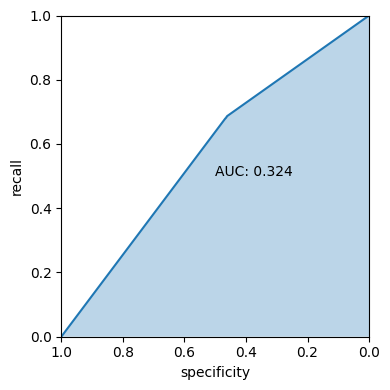

tempo de execução: 61.86343431472778 segundos
Validação cruzada para o modelo Árvore de decisões (log_loss)
0.9241980738922587


Métricas de classificação para Árvore de decisões (log_loss) no conjunto de teste: 
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     20165
         1.0       0.92      1.00      0.96    245454

    accuracy                           0.92    265619
   macro avg       0.96      0.50      0.48    265619
weighted avg       0.93      0.92      0.89    265619




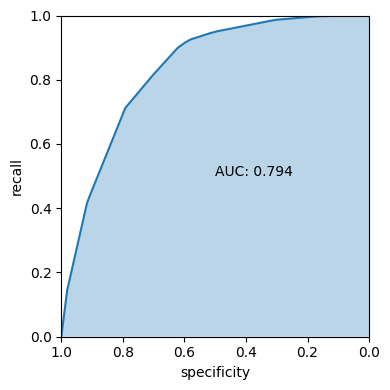

tempo de execução: 223.9755563735962 segundos
Validação cruzada para o modelo Árvore de decisões (gini)
0.9241980738922587


Métricas de classificação para Árvore de decisões (gini) no conjunto de teste: 
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     20165
         1.0       0.92      1.00      0.96    245454

    accuracy                           0.92    265619
   macro avg       0.96      0.50      0.48    265619
weighted avg       0.93      0.92      0.89    265619




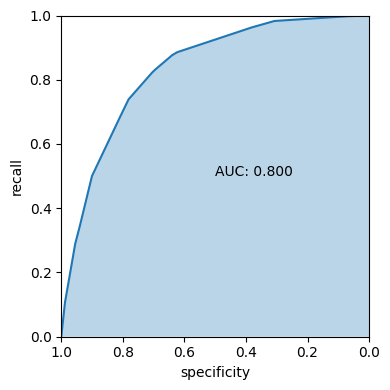

tempo de execução: 377.43623995780945 segundos
Validação cruzada para o modelo Árvore de decisões (entrópica)
0.9241980738922587


Métricas de classificação para Árvore de decisões (entrópica) no conjunto de teste: 
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     20165
         1.0       0.92      1.00      0.96    245454

    accuracy                           0.92    265619
   macro avg       0.96      0.50      0.48    265619
weighted avg       0.93      0.92      0.89    265619




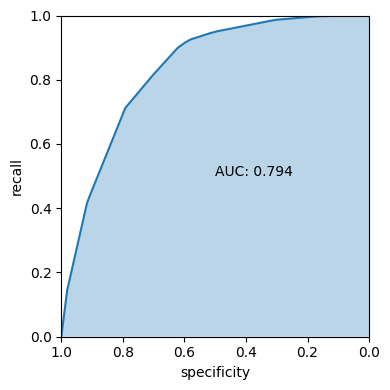

tempo de execução: 193.36646509170532 segundos
Validação cruzada para o modelo Árvore de decisões extra (log_loss)
0.9241980738922587


Métricas de classificação para Árvore de decisões extra (log_loss) no conjunto de teste: 
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     20165
         1.0       0.92      1.00      0.96    245454

    accuracy                           0.92    265619
   macro avg       0.96      0.50      0.48    265619
weighted avg       0.93      0.92      0.89    265619




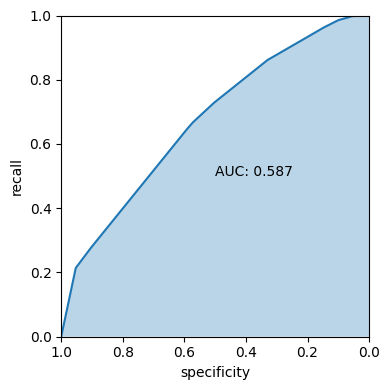

tempo de execução: 27.463159322738647 segundos
Validação cruzada para o modelo Árvore de decisões extra (gini)
0.9241980738922587


Métricas de classificação para Árvore de decisões extra (gini) no conjunto de teste: 
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     20165
         1.0       0.92      1.00      0.96    245454

    accuracy                           0.92    265619
   macro avg       0.96      0.50      0.48    265619
weighted avg       0.93      0.92      0.89    265619




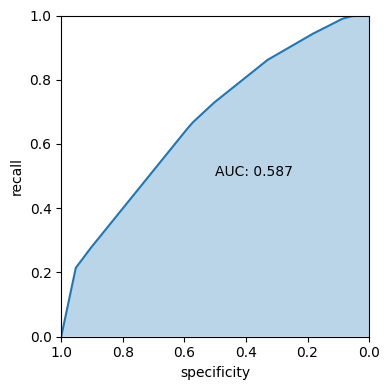

tempo de execução: 24.650563716888428 segundos
Validação cruzada para o modelo Árvore de decisões extra (entrópica)
0.9241980738922587


Métricas de classificação para Árvore de decisões extra (entrópica) no conjunto de teste: 
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     20165
         1.0       0.92      1.00      0.96    245454

    accuracy                           0.92    265619
   macro avg       0.96      0.50      0.48    265619
weighted avg       0.93      0.92      0.89    265619




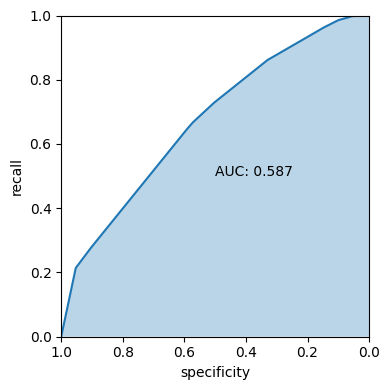

tempo de execução: 23.35753607749939 segundos


In [12]:
import time


for model in models:
    start = time.time()
    print(f"Validação cruzada para o modelo {model['name']}")
    print(cross_val_score(model["model"], X_train, y_train, cv=10).mean())
    print()
    print()
    model["model"].fit(X_train, y_train)
    y_pred_test = model["model"].predict(X_test)
    print(f"Métricas de classificação para {model['name']} no conjunto de teste: ")
    print(classification_report(y_test, y_pred_test, zero_division=1))
    print()
    fpr, tpr, thresholds = roc_curve(y_test, model['model'].predict_proba(X_test)[:, 0], pos_label=0)
    roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})
    ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
    ax.set_ylim(0, 1)
    ax.set_xlim(1, 0)
    ax.set_xlabel('specificity')
    ax.set_ylabel('recall')
    ax.text(0.5, 0.5, f'AUC: {np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)):.3f}')
    ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)
    plt.tight_layout()
    plt.show()
    end = time.time()
    print(f"tempo de execução: {end - start} segundos")

